In [1]:
import ase
import mace.calculators
import matplotlib.pyplot as plt
import numpy as np

c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\e3nn\o3\_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


La idea de este Notebook es trabajar con los conceptos de la libreria de MACE, esto como una primer aproximación al proyecto de Aprendizaje Estadistico. En teoria debe existir una segunda parte haciendo lo mismo con la libreria ASE, pues en realidad al importar mace.calculators lo que estamos haciendo es importar un "CALCULATOR" de ASE (Atomic Simularion Enviroment) 

MACE tiene su documentación para python en "https://mace-docs.readthedocs.io/en/latest/guide/guide.html". Página web que funciona similar a la documentación de Matplotlib o de Numpy. Esta posee varias secciones principales, donde cada una tiene algunas secciones secundarias, dando un vistazo por encima observamos:

- Troubleshooting and Q&A Guide
- Training
- Evaluation
- Heterogeneous Data Training
- ASE Caclulator
- MACE descriptors
- Analytic Hessians
- CUDA Acceleration with cuEquivariance Library
- OpenMM Interface
- MACE in LAMMPS with ML-IAP
- Foundation models
- Fine-tuning Foundation Models
- Multihead Replay Fine-tuning
- Multihead Training for MACE
- Larga Dataset Pre-processing
- Multi-GPUs Training

#### Q&A:

**Energy reference** (E0s) Problems: - What values should I use for atomic reference energies (E0s)?

- DFT refence energies: Use isolated atom energies calculated with exactly the same DFT settings as your dataset.
- Avarage E0s: Use `--E0s=avarage` to let MACE determine these values from your.
How do I know if my E0s are causing problems?: heck the validation loss. For energy, expected values are:
- Good E0s: Initial RMSE of 0.1-4 eV/atom
- Problematic E0s: Initial RMSE bigger than 5 eV

**Finetuning** Los mejores "foundation models" para finetuning son MPA-0 model y OMAT-O model.

- Cuando usar Multi-head finetuning? **R/** Es la manera recomendada de hacer ajuste fine si tienes acceso a los recomputed E0s para tu nuevo DFT setting.

- How many data should I use for finetuning? **R/** A starting dataset of about 10-50 diverse configurations is recommended for finetuning. An good amount is around 100.

- How should I set the hyperparameters for multi-head finetuning? **R/** A good starting point for hyperparameters for multi-head finetuning is:

```
--ema_decay=0.99999
--lr=0.0001
--num_samples_pt=100000
--forces_weight=10
--energy_weight=1
--stress_weight=1
```

**Cutoff Radius Selection** Hace refencia al vecindario (Distancia radial de interacción de cada nodo), lo recomendado esta entre los 6-7 A, donde no se recomienda distancias menores a 4 A.

Una vez elegido el radio, reduzcalo en caso de limitaciones de memoria o velocidad de computo.



#### Training

Para realizar el entrenamiento de un modelo MACE se puede usar el script run_train.py "\mace\mace\cli\run_train.py" (ubicación del script en el repo, Tómas te recomiendo hacer un fork del repo y clonarlo en tu dispositivo, "https://github.com/ACEsuit/mace/tree/main", este es el enlace) 

De una vez veo que el script es super super largo, díficil desglosarlo, pero se puede hacer el intento (lo supongo necesario dado nuestro interes partícular con el proyecto)

para su ejecución:

In [12]:
help(mace)

Help on package mace:

NAME
    mace

PACKAGE CONTENTS
    __version__
    calculators (package)
    cli (package)
    data (package)
    modules (package)
    tools (package)

VERSION
    0.3.14

FILE
    c:\users\danie\appdata\local\programs\python\python312\lib\site-packages\mace\__init__.py




In [ ]:
# se define un main()

from mace import tools

def main() -> None:
    """
    This script runs the training/fine tuning for mace
    """
    args = tools.build_default_arg_parser().parse_args()
    run(args)

# note que el main simplemente llama a run(args) donde args proviene de tools.build_default_arg_parser().parse_args()
# tools es una carpeta de MACE, en este existe el script args_parcer.py que contiene la función build_default_arg_parser()
# Esta contiene los argumentos por defecto para correr el entrenamiento/fine tuning

def run(args) -> None:

# Es realmente el código importante, que corre el entrenamiento/fine tuning
# Aquí se realiza el entrenamiento a aparit de unos argumentos (por defecto se pueden
# emplear los del submodulo tools de MACE)

Usaremos entonces `run_train.py` el que require de los siguientes argumentos:

- `--name` : obligarotio y definel el nombre de nuestro archivo
- `--train_file`: archivo de entrenamiento 
- `--valid_file` : archivo de validación, aunque tambien puede ser una fracción del train_file
- `--test_file`: Archivo de test para la evaluación del proceso de entrenamiento.

de "run_train.py" ejecutaremos la función `run()` y le entregaremos los args requeridos, en caso de ejecutarlo como `main` basta con entregarle los argumentos mencionados arriba. 


In [ ]:
### Ejemplo de ejecución de model training de MACE desde línea de comandos
### Note que es en linux

python <mace_repo_dir>/mace/cli/run_train.py \
    --name="MACE_model" \
    --train_file="train.xyz" \
    --valid_fraction=0.05 \
    --test_file="test.xyz" \
    --config_type_weights='{"Default":1.0}' \
    --E0s='{1:-13.663181292231226, 6:-1029.2809654211628, 7:-1484.1187695035828, 8:-2042.0330099956639}' \
    --model="MACE" \
    --hidden_irreps='128x0e + 128x1o' \
    --r_max=5.0 \
    --batch_size=10 \
    --max_num_epochs=1500 \
    --swa \
    --start_swa=1200 \
    --ema \
    --ema_decay=0.99 \
    --amsgrad \
    --restart_latest \
    --device=cuda \

**Model options**
The `--model` flag specifies the type of model to be trained. The vanilla MACE model is specified by `--model="MACE"`. The `--model="ScaleShiftMACE"` model includes a residual connection at first, which will usually improve the model’s accuracy but will make the model output incorrect isolated atoms energies. Use this model if you are not interested in bond-breaking energies. To train a model on dipole moments, use `--model="AtomicDipolesMACE"`. If you want to also train simultaneously on energies, use `--model="EnergyDipolesMACE"`.

**Reference energies**
It is usually preferred to add the isolated atoms to the training set, rather than reading in their energies through the command line like in the example above. To label them in the training set, set `config_type=IsolatedAtom` in their info fields. If you prefer not to use or do not know the energies of the isolated atoms, you can use the option `--E0s="average"` which estimates the atomic energies using least squares regression.

**Data keys**
When parsing the data files, the energies are read using the keyword energy and the forces using the keyword forces. To change that, specify the `--energy_key` and `--forces_key`. You can also specify `--stress_key` to read the stress tensor, `--virials_key` to read the virial tensor, and `--dipole_key` to read the dipole moments.

#### Evaluation
To evaluate your MACE model on an XYZ file, run the `eval_configs.py`:

In [ ]:
python3 <mace_repo_dir>/mace/cli/eval_configs.py \
    --configs="your_configs.xyz" \
    --model="your_model.model" \
    --output="./your_output.xyz"

#### Supported File Formats
MACE can handle a mix of the following file formats:

- **ASE files**: Standard ASE-readable atomic structure files
- **HDF5 files**: Pre-processed data in .h5 or .hdf5 format
- **LMDB databases**: Efficient storage and access for large datasets

#### MACE descriptors

MACE descriptors are atomic features obtained after each message passing block of a MACE model. As MACE is a very expressive model, these descriptors are rich and can be used for various tasks, such as classification or analysis. To extract these descriptors directly from an `ase.Atoms` object, you can use the convenient function provided in the `MACECalculator` class. \
Currently only the base `MACE` and `ScaleShiftMACE` models are supported. By default, only the invariant part of the descriptors is returned. To get the full descriptors, you can set the invariants_only argument to `False`.

In [ ]:
### Nota: Tómas, debemos usar esto para ver que info me da el descriptor

from ase.io import read
import numpy as np
from mace.calculators import MACECalculator
calculator = MACECalculator(model_paths='/content/checkpoints/MACE_model_run-123.model', device='cuda')
init_conf = read('BOTNet-datasets/dataset_3BPA/test_300K.xyz', '0')
descriptors = calculator.get_descriptors(init_conf)

In [13]:
from ase import build
from mace.calculators import mace_mp

# 1. Construimos la molécula H2
atoms_H2 = build.molecule('CO2')  # 2 átomos, con una distancia de enlace razonable

print(atoms_H2.get_angle(0, 1, 2))

calc = mace_mp(model="small", device="cpu")
atoms_H2.calc = calc


descriptor = calc.get_descriptors(atoms_H2)
print("Descriptor:\n", descriptor)

0.0
Using Materials Project MACE for MACECalculator with C:\Users\danie\.cache\mace/20231210mace128L0_energy_epoch249model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\mace\calculators\mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
Default dtype float32 does not match model dtype float64, converting models to float32.
Descriptor:
 [[-8.25420141e-01 -5.93883216e-01 -1.06220734e+00  4.00500536e-01
  -3.64431351e-01 -3.58263314e-01  1.72505975e-02  3.83215964e-01
   3.77538055e-01 -1.92659557e-01  4.04263645e-01 -3.13444555e-01
   7.96657801e-02  7.19770342e-02  7.15307295e-02  2.76386857e-01
   3.17035437e-01 -8.97342086e-01 -7.68127263e-01  2.84832984e-01
   5.55766582e-01 -3.19052130e-01  7.29524016e-01  2.01876044e-01
   6.78748727e-01  1.73135772e-01  6.88521326e-01  4.97784317e-02
   1.96632773e-01 -1.52994692e-01 -5.82559407e-01  9.01392698e-01
  -2.96975344e-01  8.80126774e-01 -3.95885929e-02 -2.19592422e-01
   4.82643545e-01  3.10129344e-01 -4.55336571e-01  1.16591066e-01
   5.92252076e-01 -8.98887813e-01 -1.19351283e-01 -5.75632572e-01
  -1.10900247e+00 -6.03054523e-01 -5.03929615e-01  9.46947187e-02
   9.74230319e-02  7.59249330e-01 -1.06517649e+00  1.67289406e-01
  -

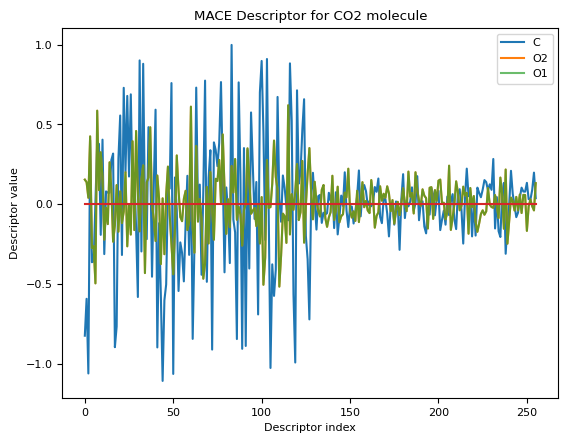

In [22]:
descriptor.shape

plt.plot(descriptor[0],label='C')
plt.plot(descriptor[2],label='O2')
plt.plot(descriptor[1],label='O1',alpha=0.7)

plt.plot(descriptor[1] - descriptor[2])

plt.legend()
plt.xlabel('Descriptor index')
plt.ylabel('Descriptor value')
plt.title('MACE Descriptor for CO2 molecule')
plt.show()


#### Analytical Hessians
The analytical hessian can be computed using ASE calculator, as in the following example:

Note: The implementation of analytical Hessians in MACE is based on the methodology described in [1]. Users are encouraged to cite this paper when using Hessians in their work. 

[1] Nils Gönnheimer, Karsten Reuter, and Johannes T. Margraf, Journal of Chemical Theory and Computation 2025, 21 (9), 4742–4752. DOI:10.1021/acs.jctc.4c01790

In [26]:
from mace.calculators import mace_mp
from ase import build

atoms = build.molecule('H2O')
calc = mace_mp(model="medium", dispersion=False, default_dtype="float64",device='cpu')
atoms.calc = calc
hessian = calc.get_hessian(atoms=atoms)
print(hessian)

Using Materials Project MACE for MACECalculator with C:\Users\danie\.cache\mace/20231203mace128L1_epoch199model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using head Default out of ['Default']


c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\mace\calculators\mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


[[[-3.79277035e-01  0.00000000e+00  0.00000000e+00]
  [ 1.89638518e-01  0.00000000e+00  0.00000000e+00]
  [ 1.89638518e-01  0.00000000e+00  0.00000000e+00]]

 [[ 0.00000000e+00  6.20668820e+01  0.00000000e+00]
  [ 0.00000000e+00 -3.10334410e+01  2.43941980e+01]
  [ 0.00000000e+00 -3.10334410e+01 -2.43941980e+01]]

 [[ 0.00000000e+00  0.00000000e+00  4.24280531e+01]
  [ 0.00000000e+00  1.82877611e+01 -2.12140266e+01]
  [ 0.00000000e+00 -1.82877611e+01 -2.12140266e+01]]

 [[ 1.89638518e-01  0.00000000e+00  0.00000000e+00]
  [-2.09743290e-01  0.00000000e+00  0.00000000e+00]
  [ 2.01047725e-02  0.00000000e+00  0.00000000e+00]]

 [[ 0.00000000e+00 -3.10334410e+01  1.82877611e+01]
  [ 0.00000000e+00  3.31989392e+01 -2.13409796e+01]
  [ 0.00000000e+00 -2.16549827e+00  3.05321844e+00]]

 [[ 0.00000000e+00  2.43941980e+01 -2.12140266e+01]
  [ 0.00000000e+00 -2.13409796e+01  2.00215288e+01]
  [ 0.00000000e+00 -3.05321844e+00  1.19249776e+00]]

 [[ 1.89638518e-01  0.00000000e+00  0.00000000e+00]


In [27]:
hessian.shape

(9, 3, 3)

MACE además de ser empleado en ASE, puede utilizarse como potencial en algunos de los simuladores de ambientes atómicos más famosos, como lo  son:

- **OpenMM**
- **LAMMPS**
- **LAMMPS with ML-IAP**

### Foundation models

#### Pretrained MACE-MP models

Se colaboro con Material Project (MP) para entrenar un "universal MACE checkpoints" cubrieno 89 elemmentos en 1.6 M bulk crystals en la MPTrj dataset

In [28]:
from mace.calculators import mace_mp
from ase import build

macemp = mace_mp() # return ASE calculator
atoms = build.molecule('H2O')
descriptors_mp = macemp.get_descriptors(atoms)

Using medium MPA-0 model as default MACE-MP model, to use previous (before 3.10) default model please specify 'medium' as model argument
Cached MACE model to C:\Users\danie\.cache\mace/macempa0mediummodel
Using Materials Project MACE for MACECalculator with C:\Users\danie\.cache\mace/macempa0mediummodel
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


c:\Users\danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\mace\calculators\mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head default out of ['default']
Default dtype float32 does not match model dtype float64, converting models to float32.


### Fine-tuning Foundation Models

Fine-tuning is the process of refining a pre-trained model on a new dataset. This is useful when you want better quantitative performance on a specific task than the available pre-trained models. Fine-tuning usually leads to significant improvements in performance compared to training a model from scratch. We have two types of fine-tuning protocols:

- The `naive fine-tuning protocol`, where the model is trained on the new dataset just by restarting from the foundation model weights.

- The `multihead replay fine-tuning protocol`, where the model is trained on the new dataset while replaying a part of the original foundational model training data.

#### Naive Fine-tuning
The naive fine-tuning protocol is the simplest way to fine-tune a model. For example to finetune the small model on a new dataset, you can use:

In [ ]:
mace_run_train \
    --name="MACE" \
    --foundation_model="small" \
    --multiheads_finetuning=False \ # Note aqui el False para no usar multiheads
    --train_file="train.xyz" \
    --valid_fraction=0.05 \
    --test_file="test.xyz" \
    --energy_weight=1.0 \
    --forces_weight=1.0 \
    --E0s="average" \
    --lr=0.01 \
    --scaling="rms_forces_scaling" \
    --batch_size=2 \
    --max_num_epochs=6 \
    --ema \
    --ema_decay=0.99 \
    --amsgrad \
    --default_dtype="float64" \
    --device=cuda \
    --seed=3

### Multihead Replay Finetuning

El "Multihead replay finetuning" es una tecnica en MACE que permite hacer un `ajuste fino` a un foundation model simultaneamente en tu dataset y en un `replay` dataset del módelo fundacional. Este acercamiento ayuda a prevenir un olvido catastrofico y mantiene las capacidades generales del modelo mientras se adapta al caso especifico.

La documentación nos determina tres diferentes acercamientos al multihead finetuning, donde la eleción del `replay dataset` varia.

#### Opciones de Replay Dataset

Los replay dataset se encuentras disponibles en https://github.com/ACEsuit/mace-foundations/releases, hay dos tipos de replay dataset disponibles.

- **Mode 1 Replay:** Datos de entrenamiento originales con DFT labels correctos
- **Mode 2 Replay:** Diversas configuraciones evaluadas con el "foundation model"

El segundo enfoque se basa en preservar el comportamineto previo del modelo, más que grantizar la precisión de los niveles de suelo.

#### Metodo 1: Preprocesamiento via CLI

El primer approuch usa el script `fine_tuning_selct.py` presente en el módulo `CLI` de MACE, esto para prepara el replay dataset antes del entranamiento.
Para esto ejecutamos el script:



In [ ]:
python -m mace.cli.fine_tuning_select \
  --configs_pt path/to/replay_dataset.xyz \
  --configs_ft path/to/your_dataset.xyz \
  --num_samples 10000 \
  --subselect fps \
  --model path/to/foundation_model.model \
  --output selected_configs.xyz \
  --filtering_type combinations \
  --head_pt pt_head \
  --head_ft target_head \
  --weight_pt 1.0 \
  --weight_ft 10.0

Donde los Key parameters son:

- `--configs_pt`: Path to the replay dataset

- `--configs_ft`: Path to your target dataset

- `--num_samples`: Number of configurations to select from the replay dataset

- `--subselect`: Method for subselection (`fps` for Farthest Point Sampling or `random`)

- `--filtering_type`: How to filter configurations based on elements:

    - `combinations`: Keep configurations with combinations of elements in your target dataset

    - `exclusive`: Keep configurations containing only elements in your target dataset

    - `inclusive`: Keep configurations containing all elements in your target dataset

    - `none`: No filtering

- `--atomic_numbers`: Optionally specify specific atomic numbers to filter by

Luego entrena el módelo usando.

In [ ]:
python -m mace.cli.run_train \
  --name mymodel_finetuned \
  --pt_train_file selected_configs.xyz \
  --train_file path/to/your_dataset.xyz \
  --valid_fraction 0.05 \
  --foundation_model path/to/foundation_model.model \
  --energy_weight 1.0 \
  --forces_weight 100.0 \
  --swa \
  --swa_energy_weight 10.0 \
  --swa_forces_weight 100.0

#### Method 2: MP atajos para modelos compatibles

MACE facilita un "automatic pre-trained data" para modelos fundacionales basados en Materials Project (MP) database o database con DFT compatibles. Puedes usar el valor espcail `mp` para el parametro `--pt_train_file` de modo que se descargue y usea automaticamente un replay dataset apropiado.

In [ ]:
python -m mace.cli.run_train \
  --train_file path/to/your_dataset.xyz \
  --foundation_model medium \
  --pt_train_file mp \
  --atomic_numbers "[1, 6, 7, 8]" \
  --multiheads_finetuning True

Los medelos compatibles con este metodo son:

- **MACE-MP-0**
- **MACE-MP-0b**
- **MACE-MP-0b2**
- **MACE-MP-0b3**
- **MACE-MPA-0**

#### Metodo 3: Multihead FIntuning directo con run_train

El segundo acergamiento integra la seleción del dataset directamente en el training process usando `run_train.py`

In [ ]:
python -m mace.cli.run_train \
  --name mymodel_finetuned \
  --train_file path/to/your_dataset.xyz \
  --foundation_model path/to/foundation_model.model \
  --pt_train_file path/to/replay_dataset.xyz \
  --num_samples_pt 10000 \
  --filter_type_pt combinations \
  --subselect_pt fps \
  --weight_pt 1.0 \
  --atomic_numbers "[1, 6, 7, 8]" \
  --multiheads_finetuning True \
  --force_mh_ft_lr False

**Key parameters:**

- `--train_file`: Your target dataset

- `--foundation_model`: Path to the foundation model

- `--pt_train_file`: Path to the replay dataset (or use “mp” for Materials Project data)

- `--num_samples_pt`: Number of samples to use from the replay dataset

- `--filter_type_pt`: Filtering strategy for configurations

- `--subselect_pt`: Method for subselection (`fps` or `random`)

- `--weight_pt`: Weight for the pretraining head loss

- `--atomic_numbers`: Critical parameter specifying which elements to keep in the replay dataset

- `--multiheads_finetuning`: Enable multihead finetuning

- `--force_mh_ft_lr`: By default, multihead finetuning uses a lower learning rate (0.0001) and enables EMA. Set to True to override this behavior.

Respecto al parametro `--atomic_numbers`, se debe entregar una lista con todos los elementos que se desean incluir en el replay `  --atomic_numbers "[1, 6, 7, 8]"  `

### Advanced Configuration: Using Heads Dictionary
For more complex scenarios, you can define a heads dictionary to customize each head:

In [ ]:
python -m mace.cli.run_train \
  --name mymodel_finetuned \
  --foundation_model path/to/foundation_model.model \
  --multiheads_finetuning True \
  --heads "{'target_head': {'train_file': 'path/to/your_dataset.xyz', 'E0s': 'path/to/e0s.json'}, 'pt_head': {'train_file': 'path/to/replay_dataset.xyz', 'E0s': 'foundation'}}" \
  --atomic_numbers "[1, 6, 7, 8]" \
  --energy_weight 1.0 \
  --forces_weight 100.0

### Monitoring and Evaluating

Durante el entrenamiento, MACE entregara metricas para el target dataset y para el replay dataset, es normal apreciar diferencias en el desempeño entre las cabezas. Tu modelo esta balanceando el aprender acerca de tus datos especificos mientras preserva el conocmieinto del entrenamiento del foundation model.
Para obtener la cabeza final tras entrenar, se puede usar `mace_select_head` presente en el modulo `CLI` para obtener una única cabeza para el despliegue del modelo.

Si se esta usando el modelo de dos cabezas como una calculadora ASE, puedes especificar cual de las dos estas empleando, ya sea la fine-tuned (llamada mediante `head = "default"`) o emplear la preentrenada mediante `"pt_head"`

### Tips para un correcto Multihead Finetuning

- **Check the initial performance:** Monitor the initial performance of the models when finetuning. If you see that the initial error on your dataset is very high (> 0.4 eV/atom), it is likely that you need to adjust your E0s. You can use the `--E0s` parameter to provide a custom E0s file.

- **Use the right E0s:** It is also very important that you compute your own E0s and not use “average” option. When computing your E0s, please use **spin polarized calculations**. If you are using MP compatible DFT, you can use the option `–E0s=”foundation”` to use the same E0s as the foundation model.

- **Balance head weights:** Adjust `--weight_pt` and `--weight_ft` to control the importance of each dataset. Higher values for your target dataset will focus more on performance for your specific application.

- **Choose the right replay mode:** If you have access to true DFT labels, compare carefully mode 1 and mode 2 of replay datasets.

- **Element selection:** Carefully choose which elements to include using `--atomic_numbers`. Including unnecessary elements increases computational cost.

- **Dataset size ratio:** It usually gives best performance to use as many replay sample as you can. Use `--num_samples_pt` to control this (30000 is a good value). As your input data will be repeatedly sampled, you can use a smaller number of epochs.

- **Number of epochs for training:** The number of epochs for convergence is between 10 and 30 epochs. Larger number of sampler might reduce the number of epochs to convergence.

- **EMA and learning rate:** Use `--ema` and `--ema_decay` to stabilize training. To change the default values for EMA and learning rate, use the `–force_mh_ft_lr` parameter. The default learning rate for multihead finetuning is 0.0001, which is lower than the default learning rate for single head finetuning (0.001). This helps to stabilize the training process and prevent overfitting.

- **Weight Decay:** Turning down the weight decay might help boost performance, you can experiment with setting values from 5e-7 to 0.0, going down by factors of 10.

### Multihead Training for MACE

MACE soporta entrenamientos en multiples niveles de teorías simultáneamente. Esto es llamado entrenamiento multihead. En orden de hacer esto MACE construye tantas readout functions como numeros de niveles de toerias. El resto de pesos son compartidos. Esto permite que el modelo aprenda diferentes niveles de teorias simultaneamente, que son potenicialmente incosnsitentes entre ellos.

Para entrenar un modelo multihead, puedes usar el script `mace_run_train` con los siguientes archivos yaml en el argumento `-config`

In [ ]:
# yaml file for multiheads training models

heads:
    3bpa_wb97x_d3bj:
        train_file: "train_3bpa_wb97x_d3bj.xyz"
        valid_file: "val_3bpa_wb97x_d3bj.xyz"
        E0s: "e0s_wb97x_d3bj.json"
        energy_key: "dft_energy"
        forces_key: "dft_forces"

    3bpa_ccdt:
        train_file: "train_3bpa_ccdt.xyz"
        valid_file: "val_3bpa_ccdt.xyz"
        E0s: "e0s_ccdt.json"
        energy_key: "ccdt_energy"
        forces_key: "ccdt_forces"